## Using Neural Networks for building a heatmap of taxi trip durations in New York City
DataQubit 2019

In [2]:
import numpy as np
import pandas as pd
import os
import bq_helper
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [3]:
from keras import metrics

In [4]:
import keras

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.metrics import mean_squared_error

In [ ]:
# create a helper object for this dataset
nyc_open_data = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                              dataset_name="new_york")

In [ ]:
nyc_open_data.list_tables()

In [ ]:
nyc_open_data.head("tlc_yellow_trips_2016")

In [ ]:
qu_extract_trips = """
SELECT 
    pickup_datetime, 
    dropoff_datetime,
    pickup_longitude,
    pickup_latitude,
    dropoff_longitude,
    dropoff_latitude
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
"""

In [8]:
df_yell_jan = pd.read_csv('../input/new-york/nyc_yellow_trips_geo_time_Only_2016_Jan.csv')

In [9]:
df_yell_jan = df_yell_jan.query('(pickup_longitude!=0.) & (pickup_latitude!=0) & (dropoff_longitude!=0.) & (dropoff_latitude!=0)')

In [10]:
df_yell_jan['pickup_datetime'] = pd.to_datetime(df_yell_jan.pickup_datetime)

In [11]:
df_yell_jan['dropoff_datetime'] = pd.to_datetime(df_yell_jan.dropoff_datetime)

In [12]:
# minutes since midnight
df_yell_jan['pickup_day_minute'] = df_yell_jan.pickup_datetime.dt.hour * 60 + df_yell_jan.pickup_datetime.dt.minute

In [13]:
df_yell_jan['duration'] = (df_yell_jan.dropoff_datetime - df_yell_jan.pickup_datetime).dt.seconds

In [14]:
# Filter out trips longer than 1 hour:
df_yell_jan = df_yell_jan.query('duration <= 3600.')

In [15]:
df_yell_jan.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_day_minute,duration
0,2016-01-19 21:16:24,2016-01-19 21:34:19,-73.874611,40.774120,-73.989937,40.733994,1276,1075
1,2016-01-16 15:40:08,2016-01-16 15:42:14,-73.880005,40.636147,-73.897346,40.616409,940,126
2,2016-01-03 15:22:20,2016-01-03 15:55:33,-73.985603,40.759941,-73.866646,40.771221,922,1993
3,2016-01-02 05:17:35,2016-01-02 05:35:56,-73.962372,40.772877,-73.870316,40.773258,317,1101
4,2016-01-04 03:55:50,2016-01-04 04:13:30,-73.950020,40.780552,-73.873444,40.771469,235,1060


In [16]:
(df_yell_jan.pickup_longitude==0.).mean(), (df_yell_jan.dropoff_longitude==0.).mean()

(0.0, 0.0)

In [ ]:
len(df_yell_jan)

In [ ]:
len(df_yell_jan)

In [ ]:
df_yell_jan.duration.div(3600.).plot(kind='hist', bins=50, figsize=(20, 5), logy=True)

In [ ]:
df_yell_jan.duration.div(3600.).plot(kind='hist', bins=50, figsize=(20, 5), logy=False, cumulative=True)

In [ ]:
df_yell_jan.duration.div(3600.).plot(kind='hist', bins=50, figsize=(20, 5), logy=True)b

In [ ]:
df_yell_jan[df_yell_jan.duration.div(3600.) < 1].duration.div(3600.).plot(kind='hist', bins=50, figsize=(20, 5), logy=False, cumulative=True)

#### Train/Test split and transformation

We will try to use least amount of RAM

In [17]:
# standardization
stSc = StandardScaler()

In [ ]:
stSc

In [18]:
df_yell_jan.columns

Index(['pickup_datetime', 'dropoff_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'pickup_day_minute', 'duration'],
      dtype='object')

In [19]:
feature_cols = df_yell_jan.columns[2:-1]

In [20]:
feature_cols

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_day_minute'],
      dtype='object')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(stSc.fit_transform(df_yell_jan[feature_cols]), 
                                                                       df_yell_jan.duration, test_size=0.33, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
X_train.shape

(7133812, 5)

### Model build

In [23]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=5))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
              metrics=[metrics.mse])

In [26]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.25)

Instructions for updating:
Use tf.cast instead.
Train on 5350359 samples, validate on 1783453 samples
Epoch 1/5
5350359/5350359 [==============================] - 269s 50us/step - loss: 123628.2033 - mean_squared_error: 123628.2033 - val_loss: 82460.6900 - val_mean_squared_error: 82460.6900
Epoch 2/5
5350359/5350359 [==============================] - 273s 51us/step - loss: 83945.2443 - mean_squared_error: 83945.2443 - val_loss: 80191.1310 - val_mean_squared_error: 80191.1310
Epoch 3/5
5350359/5350359 [==============================] - 271s 51us/step - loss: 84045.6098 - mean_squared_error: 84045.6098 - val_loss: 78453.7995 - val_mean_squared_error: 78453.7995
Epoch 4/5
5350359/5350359 [==============================] - 267s 50us/step - loss: 79258.3824 - mean_squared_error: 79258.3824 - val_loss: 86780.2779 - val_mean_squared_error: 86780.2779
Epoch 5/5
5350359/5350359 [==============================] - 271s 51us/step - loss: 79357.6127 - mean_squared_error: 79357.6127 - val_loss: 8284

In [ ]:
history.history

In [ ]:
# Plot training & validation accuracy values
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot(figsize=(15, 5), linewidth=4)

In [ ]:
# Plot training & validation accuracy values
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot(figsize=(15, 5), linewidth=4)

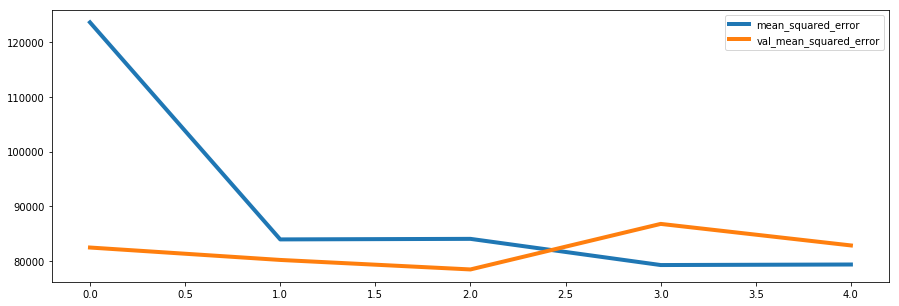

In [27]:
# Plot training & validation accuracy values
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot(figsize=(15, 5), linewidth=4)

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_test_pred)

In [ ]:
for pred, tst in zip(y_test_pred[:100], y_test[:100]):
    print(pred[0], tst, (pred[0] - tst) / 60.)

In [ ]:
df_yell_jan.iloc[:10000].plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.2, xlim=[-74.05, -73.8], ylim=[40.7, 40.85], figsize=(10, 10))

In [28]:
df_subs = df_yell_jan.iloc[:10000][
    (df_yell_jan.iloc[:10000].dropoff_longitude.between(-74.03, -73.94) & df_yell_jan.iloc[:10000].dropoff_latitude.between(40.7, 40.8))][['dropoff_longitude', 'dropoff_latitude']]

In [29]:
df_subs.head()

,dropoff_longitude,dropoff_latitude
0,-73.989937,40.733994
6,-73.980896,40.782578
9,-73.980270,40.782291
10,-73.977928,40.759731
12,-74.011200,40.701870


In [30]:
def plot_duration_map(pick_long, pick_lat, pick_d_min):
    X_map = np.vstack([pick_long * np.ones(len(df_subs)), 
                      pick_lat * np.ones(len(df_subs)),
                      df_subs.dropoff_longitude.values,
                      df_subs.dropoff_latitude.values,
                      pick_d_min * np.ones(len(df_subs))]).T
    df_subs['pred_duration'] = model.predict(stSc.transform(X_map)) / 60.
    df_subs.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.5, figsize=(7, 6), c='pred_duration', sharex=False,
                 cmap=plt.get_cmap('Paired'))
    plt.plot(pick_long, pick_lat, 'X', markersize=15, color='darkblue')
    plt.show()

### Neural Net Prediction for Trip Duration From Different Points in Manhattan

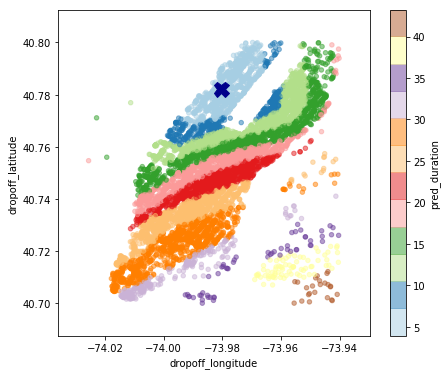

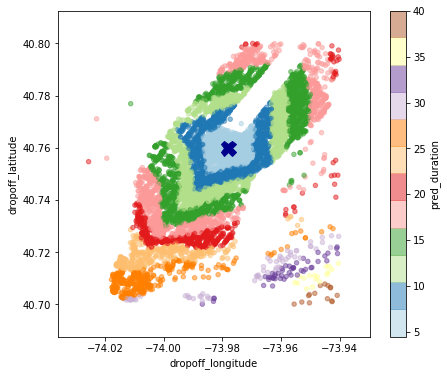

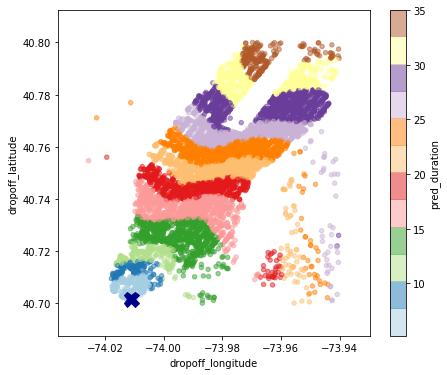

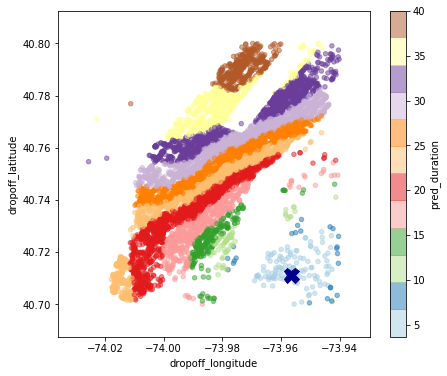

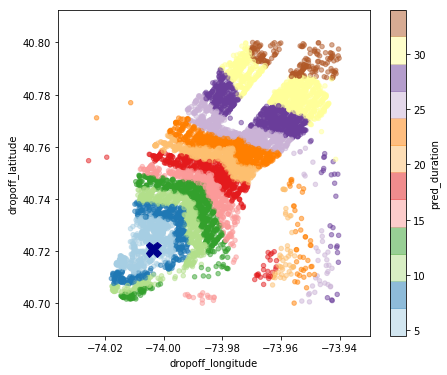

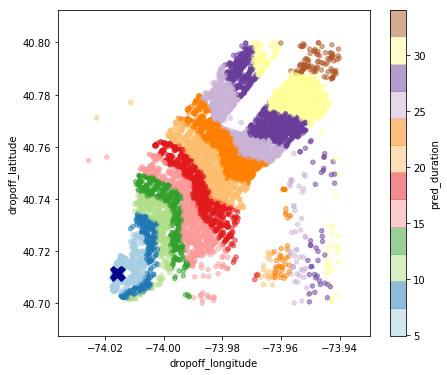

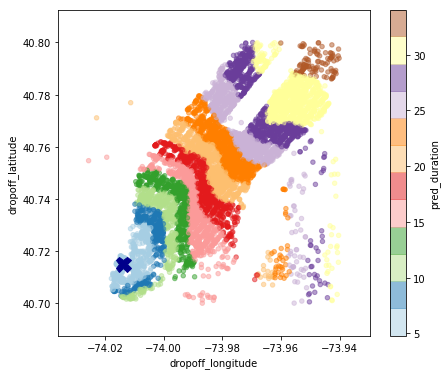

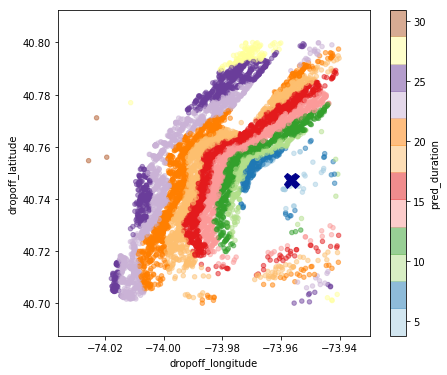

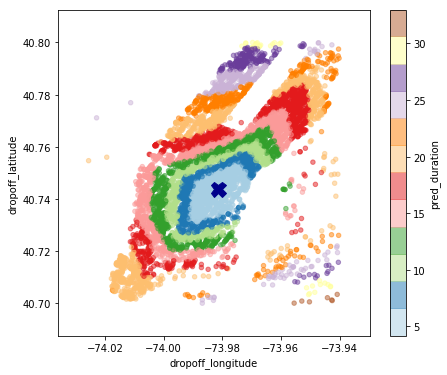

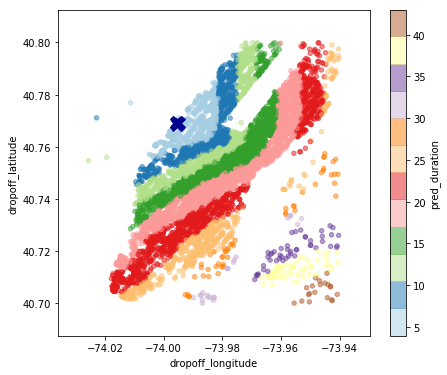

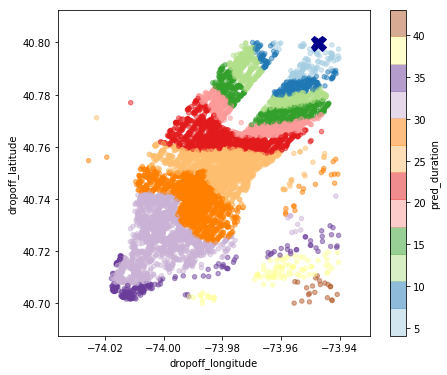

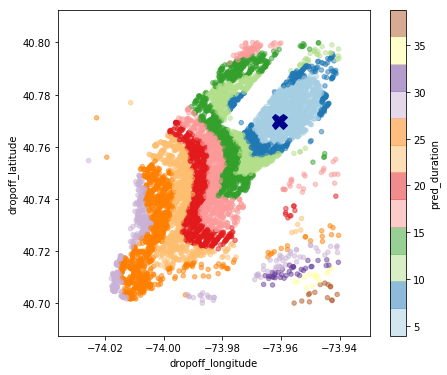

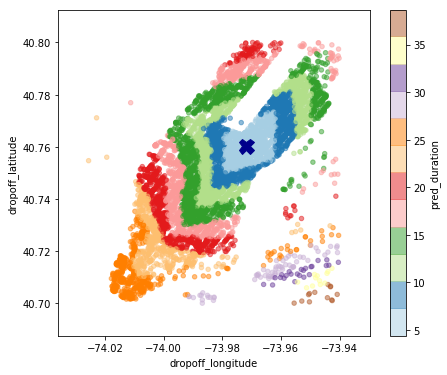

In [31]:
for j in range(2, 15):
    plot_duration_map(df_subs.dropoff_longitude.iloc[j], df_subs.dropoff_latitude.iloc[j], 1000)